# [Geometric Methods for Machine Learning](http://marcocuturi.net/)
## _Memory Efficient Kernel Approximation_. Si Si, Cho-Jui Hsieh, Inderjit S. Dhillon (2017)
_Chloé Baraille, Othmane Sebbouh_

In this notebook, We implement the method developed in the article _Si et al. (2017)_ called **Memory Efficient Kernel Approximation (MEKA)**. It consists of a new method for low rank kernel factorization, which succeeds to achieve lower approximation errors compared to state of the art methods like the standard **Nyström method**, while being faster and using less memory.

This notebook is organized in two parts.
- In the first part, we implement the standard Nyström method and MEKA for kernel factorization.
- In the second, we compare the performance of these two methods on different grounds: robustness to the scaling parameter and to the number of clusters (for MEKA), time and memory efficiency, kernel-SVM accuracy.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tick
from scipy.linalg import norm, block_diag
from scipy import sparse

import numpy.linalg as LA
from sklearn.metrics.pairwise import rbf_kernel, laplacian_kernel

from sklearn.cluster import KMeans
import time

Loading the `ijcnn1` dataset.

In [2]:
from tick.dataset import fetch_tick_dataset

data = fetch_tick_dataset('binary/ijcnn1/ijcnn1.trn.bz2')[0].toarray()
target = fetch_tick_dataset('binary/ijcnn1/ijcnn1.trn.bz2')[1]
print(data.shape)
n, d = data.shape

(49990, 22)


For faster computations, we will work on a smaller dataset.

In [3]:
big = False

One can choose the size they want by setting the desired size in the variable `size`.

In [4]:
from sklearn.model_selection import train_test_split

if big:
    X, y = data, target
    size = len(X)
else:
    size = 10000
    ind = np.random.choice(len(data), size, replace=False)
    X, y = data[ind], target[ind]

Here, we give some functions that are used by both the standard Nyström method and MEKA. They are functions that allow to:
- cluster the data into $c$ clusters
- sample some observations for the Nyström approximations of the diagonal approximations.
- compute a rank-$k$ pseudo inverse
- perform a Nyström approximation that returns the diagonal matrices $W$ and $L$.

In [5]:
def clustering(X, c):
    """returns c clusters of data in the form of lists of indices"""
    kmeans = KMeans(n_clusters=c)
    clusters_index = kmeans.fit_predict(X)
    clusters = [np.where(clusters_index == i)[0] for i in range(c)]
    centers = kmeans.cluster_centers_
    return clusters, centers


def sampling(indices, m):
    """ Given all the indices of the samples in a cluster, chooses m indices of the samples """
    chosen = np.random.choice(indices, m, replace=False)
    return chosen


def low_rank_inv(A, k):
    '''compute a rank-k pseudo inverse of the matrix A'''
    u, s, _ = LA.svd(A)
    U = u[:, :k]
    S = np.diag(1 / s[:k])
    A_k = np.dot(U, np.dot(S, U.T))
    return A_k


def Nystrom_decomp(X, gamma, k,  indices, chosen_indices):
    '''Given samples of a matrix G, computes its rank-k approximation
             G = W * L * W.T'''
    m = len(chosen_indices)
    n_s = len(indices)
    other_indices = np.array([ind for ind in indices if ind not in chosen_indices])
    d = {}

    L_inv = rbf_kernel(X[chosen_indices], gamma=gamma)

    for j, index in enumerate(chosen_indices):
        d[index] = j
    
    for j, index in enumerate(other_indices):
        d[index] = j + m
        
    Wp = rbf_kernel(X[other_indices], X[chosen_indices], gamma=gamma)
    W = np.vstack((L_inv, Wp))

    L = low_rank_inv(L_inv, k)

    return W, L, d

def approx_error(A, B):
    return LA.norm(A - B, ord='fro') / LA.norm(A, ord='fro')

def pair_rbf(a, b, gamma):
    return np.exp(- gamma * LA.norm(a - b, 2) ** 2)

We are now ready to create our algorithms. Below are two classes that implement them. Each function in the class is explained in the code below.

## a) Standard Nyström Method

In [6]:
class Nystrom():
    def __init__(self, X, gamma, k, m):
        self.X = X
        self.gamma = gamma
        self.k = k
        self.m = m
        self.sampled = None
        self.size = len(self.X)
        self.time = 0
        self.ind_dic = []
        self.K_tilde = None
        self.K_true = None

    def sampling_Nystrom(self):
        """samples m observations.
        Returns the indices of the sampled observations"""
        self.sampled = sampling(self.size, self.m)
        return self.sampled

    def NYS(self):
        """creates the approximate kernel.
        Returns the approximate kernel."""
        #sampling
        indices = range(len(self.X))
        chosen_indices = self.sampling_Nystrom()

        #decomposition (W, L) and approximation
        t0 = time.time()
        W, L, self.ind_dic = Nystrom_decomp(self.X, self.gamma, self.k, indices, chosen_indices)
        K_tilde = np.dot(W, np.dot(L, W.T))
        self.time += time.time() - t0
        return K_tilde
    
    def compute_kernel(self):
        K_tilde_random = self.NYS()
        values = np.array(list(self.ind_dic.values()))
        self.K_tilde = K_tilde_random[values[:, None], values]
        return self.K_tilde

    def compute_error(self, K_true):
        """computes the approximation error.
        Returns the approximation error, the approximate kernel and the reshaped
        original kernel."""
        K_tilde = self.compute_kernel()
        err = approx_error(K_true, K_tilde)
        return err

## b)  Memory Efficient Kernel Approximation (MEKA)

In [7]:
class MEKA():
    def __init__(self, X, gamma, c, k, m, rho, epsilon=None, rank_choice='uniform'):
        self.X = X
        self.gamma = gamma
        self.c = c
        self.k = k
        self.m = m
        self.epsilon = epsilon
        self.size = len(self.X)
        self.sampled = range(len(self.X))
        self.K_tilde = 0
        self.K_true = 0
        self.D = {}
        
        #  particular to MEKA
        self.rho = rho
        self.m_MEKA = (1 + rho) * k # number of samples for the off-diagonals L_st
        
        ### about k_s
        self.rank_choice = rank_choice
        self.d_eig = {}
        
        self.ind_dic = [] # index 
        self.W = []
        self.L = []
        self.clusters = []
        self.cluster_centers = []
        
        #  time parameters
        self.Tc = 0
        self.Tw = 0
        self.Tl = 0
        self.time = self.Tc + self.Tw + self.Tl
    
    
    def diagonal_decomp(self):
        """performs the Nyström approximation of the diagonal matrices.
        returns lists composed of: the diagonal matrices W, the diagonal matrices L,
        and dictionnaries of the selected indices in each cluster"""
        cs = 0
        all_eigenvalues = []
        sampled_ev = []
        for s in range(self.c):
            all_ind = self.clusters[s]
            if self.rank_choice == 'proportional':
                chosen_ind = sampling(all_ind, self.m)
                k_s = int(c * self.k * len(all_ind) / self.size)
                W_s, L_s, d_s = Nystrom_decomp(self.X, self.gamma, k_s, all_ind, chosen_ind)
                self.W.append(W_s)
                self.L.append(L_s)
                self.ind_dic.append(d_s)
                
                # needed to reshape the kernel to the original form of the data
                d_s_bis = {key : value + cs for key, value in d_s.items()}
                self.D.update(d_s_bis)
                cs += len(d_s_bis)
                
            elif self.rank_choice == 'uniform':
                chosen_ind = sampling(all_ind, self.m)
                k_s = self.k
                W_s, L_s, d_s = Nystrom_decomp(self.X, self.gamma, self.k, all_ind, chosen_ind)
                self.W.append(W_s)
                self.L.append(L_s)
                self.ind_dic.append(d_s)
                
                # needed to reshape the kernel to the original form of the data
                d_s_bis = {key : value + cs for key, value in d_s.items()}
                self.D.update(d_s_bis)
                cs += len(d_s_bis)
                
            elif self.rank_choice == 'ev_based':
                chosen_ind = sampling(all_ind, 2 * self.k)
                sampled_ev.append(chosen_ind)
                M_s = rbf_kernel(self.X[chosen_ind], gamma=self.gamma)
                _, eigenvalues, _ = LA.svd(M_s)
                for ev in eigenvalues:
                    self.d_eig[ev] = s
        
        if self.rank_choice == 'ev_based':
            largest_ev = sorted(self.d_eig, reverse=True)[:self.c*self.k]
            ev_cluster = np.array([self.d_eig[ev] for ev in largest_ev])
            ks = [np.sum(ev_cluster == j) for j in range(self.c)]
            for s in range(self.c):
                all_ind = self.clusters[s]
                chosen_ind = sampled_ev[s]
                k_s = ks[s]
                W_s, L_s, d_s = Nystrom_decomp(self.X, self.gamma, k_s, all_ind, chosen_ind)
                self.W.append(W_s)
                self.L.append(L_s)
                self.ind_dic.append(d_s)
                
                
                d_s_bis = {key : value + cs for key, value in d_s.items()}
                self.D.update(d_s_bis)
                cs += len(d_s_bis)
            
        
        return self.W, self.L, self.ind_dic
    
    def comp_L_st(self, s, t):
        """Computes the off-diagonal matrix L_st
        Return L_st"""
        
        def sampling_st(s, t, m):
            """samples m observations from cluster s and m from cluster t"""
            v1 = np.random.choice(self.clusters[s], m, replace=False)
            v2 = np.random.choice(self.clusters[t], m, replace=False)
            return v1, v2
        
        
        
        vs, vt = sampling_st(s, t, self.m_MEKA)

        G_st = rbf_kernel(self.X[vs], self.X[vt], gamma=self.gamma)

        ind_s, ind_t = self.ind_dic[s], self.ind_dic[t]
        W_s, W_t = self.W[s], self.W[t]
        
        
        W_vs = np.zeros((self.m_MEKA, W_s.shape[1]))
        W_vt = np.zeros((self.m_MEKA, W_t.shape[1]))

        
        #Constructing W_vs and W_vt
        for i in range(self.m_MEKA):
            row_ind = vs[i]
            W_ind_s = ind_s[row_ind]
            W_vs[i] = W_s[W_ind_s]

        for j in range(self.m_MEKA):
            col_ind = vt[j]
            W_ind_t = ind_t[col_ind]
            W_vt[j] = W_t[W_ind_t]
        
        
        
        
        #computing L_st
        A = np.dot(LA.pinv(np.dot(W_vs.T, W_vs)), W_vs.T)
        B = np.dot(W_vt, LA.pinv(np.dot(W_vt.T, W_vt)))
        L_st = np.dot(np.dot(A, G_st), B)
        return L_st
    
    
    def K_MEKA(self):
        """Creates the MEKA approximate kernel.
        Returns the MEKA approximate kernel."""
        
        K_tilde = np.zeros((self.size, self.size))
        cs = 0
        for s in range(self.c):
            W_s = self.W[s]
            n_s = len(W_s)
            ct = 0
            center_s = self.cluster_centers[s]
            for t in range(self.c):
                center_t = self.cluster_centers[t]
                W_t = self.W[t]
                n_t = len(W_t)
                if s == t:
                    L_s = self.L[s]

                    t0 = time.time()
                    W = np.dot(W_s, np.dot(L_s, W_s.T))
                    self.Tw += time.time() - t0


                    K_tilde[cs:cs + n_s, cs:cs + n_s] = W
                else:
                    if self.epsilon is not None:
                        center_dist = pair_rbf(center_s, center_t, gamma=self.gamma)
                        if center_dist < self.epsilon:
                            pass
                        else:
                            t0 = time.time()
                            L_st = self.comp_L_st(s, t)
                            K_tilde_st = np.dot(W_s, np.dot(L_st, W_t.T))
                            self.Tl += time.time() - t0

                            K_tilde[cs:cs + n_s, ct:ct + n_t] = K_tilde_st
                    else:
                        t0 = time.time()
                        L_st = self.comp_L_st(s, t)
                        K_tilde_st = np.dot(W_s, np.dot(L_st, W_t.T))
                        self.Tl += time.time() - t0

                        K_tilde[cs:cs + n_s, ct:ct + n_t] = K_tilde_st

                ct += n_t
            cs += n_s
        
        return K_tilde
    

    def MEKA(self):
        """Implements the MEKA algorithm.
        Returns the MEKA approximate kernel."""
        # clustering
        t0 = time.time()
        self.clusters, self.cluster_centers = clustering(self.X, self.c)
        self.Tc += time.time() - t0
        
        # diagonal elements
        t0 = time.time()
        self.W, self.L, self.ind_dic = self.diagonal_decomp()
        self.Tw += time.time() - t0
        
        # non-diagonal elements
        K_tilde = self.K_MEKA()
        return K_tilde

    
    def reshape_kernel(self):
        """reshapes the kernel in the order of the original samples"""
        values = np.array(list(self.D.values()))
        K_tilde_modified = self.K_tilde_random[values[:, None], values]
        return K_tilde_modified
    
    def compute_kernel(self):
        self.K_tilde_random = self.MEKA()
        self.K_tilde = self.reshape_kernel()
        return self.K_tilde
    
    def modified_kernel(self):
        return self.MEKA()
    
    def compute_error(self, K_true):
        """Computes the approximation error. Returns the approximation error, 
        the approximate kernel and the reshaped original kernel."""
        K_tilde = self.compute_kernel()
        self.time = self.Tc + self.Tw + self.Tl
        err = approx_error(K_true, K_tilde)
        return err

** Test **

In [8]:
print('Calculating the whole kernel...')
gamma = 1
K_true = rbf_kernel(X, gamma=gamma)

Calculating the whole kernel...


In [9]:
c = 10
k = 10
m = 2 * k
rho = 2

print('Computing MEKA and NYS approximations with k={}, m={} and rho={}.'.format(k, m, rho))

Computing MEKA and NYS approximations with k=10, m=20 and rho=2.


In [10]:
Nys = Nystrom(X=X, gamma=gamma, k=k, m=m)
err_Nys = Nys.compute_error(K_true)
print('Approximation error of NYS:', err_Nys)

Approximation error of NYS: 0.493434593563


In [11]:
Meka = MEKA(X=X, gamma=gamma, c=c, k=k, m=m, rho=rho, epsilon=None, rank_choice='uniform')
err_Meka = Meka.compute_error(K_true)
print('Approximation error of MEKA:', err_Meka)

Approximation error of MEKA: 0.0602199728721


## Experiments on the ijcnn1 dataset and comparison with the standard Nyström method.

The aim of the remaining of the notebook is to show the benefits of MEKA, especially compared with the Nyström method. 

For all the experiments, the measure of performance we use is the relative approximation error. Noting $K$ the true kernel and $\tilde{K}$ its approximation by one of the proposed methods, the approximation error is defined as:

$$
\frac{\|K - \tilde{K}\|_{F}}{\|K\|_{F}}
$$

- ** Robustness to $\gamma$ **: First, we are going to show that the MEKA method is robust to the choice of the parameter $\gamma$, which means that Meka performs well whether the Kernel matrix presents a block diagonal structure (high $\gamma$) or a low rank one (low $\gamma$). Note that this is not the case for Block Kernel Approximation (BKA), which fails when $\gamma$ is high and for the standard Nyström method, which fails when $\gamma$ is low. As we compare Meka with the standard Nyström method, we will see that this last observation is empirically verified.

- **Robustness to the number of clusters $c$** : Compared to the standard Nyström method, MEKA introduces an additional parameter: the number of clusters. We are going to show that MEKA is robust to varying the number of clusters. Since increasing the number of clusters $c$ increases the memory usage with Meka, we increase the rank of the approximations for the standard Nyström method to have a fair comparison.

- ** Memory and time efficiency**: We will compare the two methods in terms of their memory usage and computation time. The computation time is measured empirically. Note that since performing MEKA and NYS require rearranging the kernel matrix, this costs some computational time. In computing the time for the algorithms, we only consider the time required for computing the kernel, not the reshaping time. For storage space: noting $M$ the memory usage of a method, we consider that for a rank $ck$ approximation of the kernel matrix: $M(Nyström) = cnk$ and $M(MEKA) = nk + (ck)^2$
- ** Accuracy of SVM ** : We will compare the accuracy scores of SVM with a Gaussian kernel using MEKA and NYS. The goal of the approximations is speeding up kernel-SVM when all the training and testing data are available beforehand. Note that if this is not the case, our methods are of limited use for this task.

 As it is was one of the main motivations of the article, we illustrate the results on low and high values of $\gamma$ each time. For all these comparisons, we will clearly see that MEKA outperforms the standard Nyström method.

### Robustness to the Gaussian scaling parameter $\gamma$

In [12]:
gammas = [0.01, 0.5, 2, 5, 8]

rho = 3
k = 10
m = 2 * k

all_err_Nys = []
all_err_Meka = []
for gamma in gammas:
    Nys = Nystrom(X=X, gamma=gamma, k=k, m=m)
    Meka = MEKA(X=X, gamma=gamma, c=c, k=k, m=m, rho=rho)
    K_true = rbf_kernel(X, gamma=gamma)
    err_Nys = Nys.compute_error(K_true)
    err_Meka = Meka.compute_error(K_true)
    all_err_Nys.append(err_Nys)
    all_err_Meka.append(err_Meka)

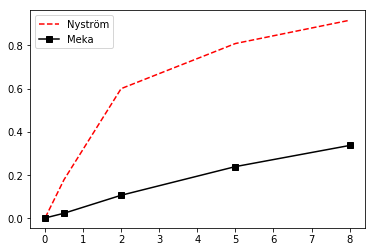

In [13]:
plt.plot(gammas, all_err_Nys, linestyle='--', color='red')
plt.plot(gammas, all_err_Meka, linestyle='-', marker='s', color='black')
plt.legend(['Nyström', 'Meka'])

### Robustness to the number of clusters $c$

In [14]:
gammas = [1, 5]
rho = 3

cs = np.linspace(5, 20, 4, dtype='int')

ks = np.linspace(20, 35, 4, dtype='int')
m1s = [2 * k for k in ks]
k = 20
m = 2 * k



all_time_Meka, all_time_Nys = [ [], [] ], [ [], [] ]
all_err_Meka, all_err_Nys = [ [], [] ], [ [], [] ]
for j, gamma in enumerate(gammas):
    K_true = rbf_kernel(X, gamma=gamma)
    for i, c in enumerate(cs):
        Nys = Nystrom(X=X, gamma=gamma, k=ks[i], m=m1s[i])
        Meka = MEKA(X=X, gamma=gamma, c=c, k=k, m=m, rho=rho)
        err_Nys = Nys.compute_error(K_true)
        err_Meka = Meka.compute_error(K_true)
        all_err_Nys[j].append(err_Nys)
        all_err_Meka[j].append(err_Meka)

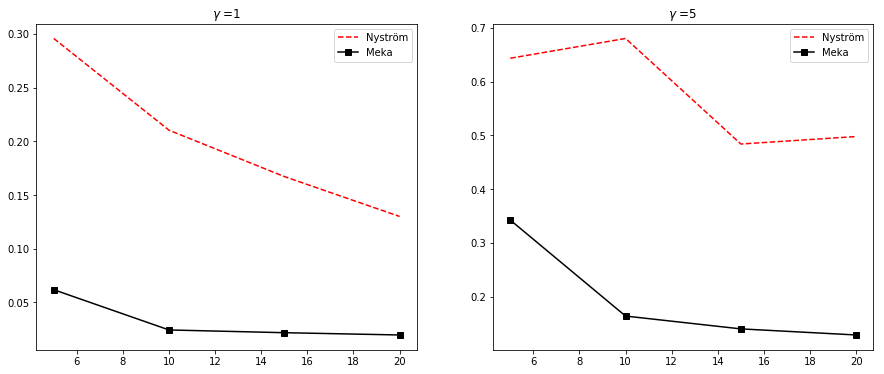

In [15]:
plt.figure(figsize=(15, 6))
for j, gamma in enumerate(gammas):
    plt.subplot(1, 2, j+1)
    plt.plot(cs, all_err_Nys[j], linestyle='--', color='red')
    plt.plot(cs, all_err_Meka[j], linestyle='-', marker='s', color='black')
    plt.title(r'$\gamma$ ={}'.format(gamma))
    plt.legend(['Nyström', 'Meka'])

### Memory efficiency of the method

In [16]:
gammas = [1, 5]
c = 10
ks = np.linspace(20, 100, 5, dtype='int')
ms = [2 * k for k in ks]

all_time_Meka, all_time_Nys = [ [], [] ], [ [], [] ]
all_err_Meka, all_err_Nys = [ [], [] ], [ [], [] ]
for j, gamma in enumerate(gammas):
    K_true = rbf_kernel(X, gamma=gamma)
    for i, k in enumerate(ks):
        Nys = Nystrom(X=X, gamma=gamma, k=k, m=ms[i])
        Meka = MEKA(X=X, gamma=gamma, c=c, k=k, m=ms[i], rho=rho)
        err_Nys = Nys.compute_error(K_true)
        err_Meka = Meka.compute_error(K_true)
        all_err_Meka[j].append(err_Meka)
        all_err_Nys[j].append(err_Nys)

In [17]:
def param_Meka(n, c, k):
    return n * k + (c * k) ** 2
def param_Nys(n, k):
    return n * k

memo_Meka = [param_Meka(n, c, k) for k in ks]
memo_Nys = [param_Nys(n, k) for k in ks]

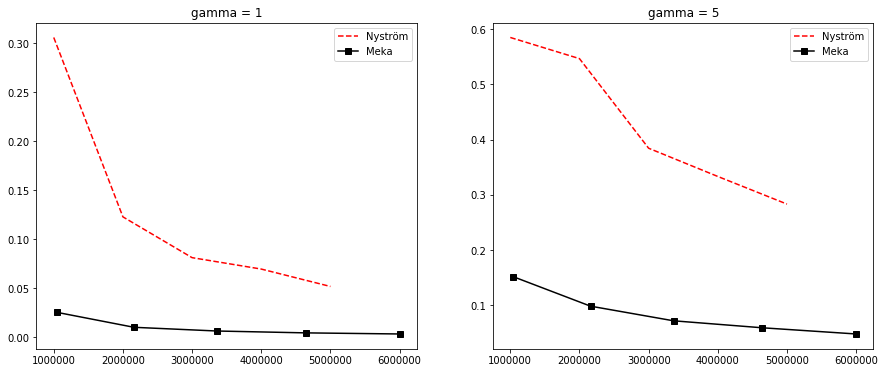

In [18]:
plt.figure(figsize=(15, 6))
for j, gamma in enumerate(gammas):
    plt.subplot(1, 2, j+1)
    plt.plot(memo_Nys, all_err_Nys[j], linestyle='--', color='red')
    plt.plot(memo_Meka, all_err_Meka[j], linestyle='-', marker='s', color='black')
    plt.legend(['Nyström', 'Meka'])
    plt.title('gamma = {}'.format(gamma))

### Time efficiency of MEKA

In [19]:
gammas = [1, 5]
c = 10
rho = 2

k1s = np.linspace(40, 120, 4, dtype='int')
k2s = np.linspace(5, 30, 4, dtype='int')
m1s = [2 * k for k in k1s]
m2s = [2 * k for k in k2s]


all_time_Meka, all_time_Nys = [ [], [] ], [ [], [] ]
all_err_Meka, all_err_Nys = [ [], [] ], [ [], [] ]
for j, gamma in enumerate(gammas):
    K_true = rbf_kernel(X, gamma=gamma)
    for i, k1 in enumerate(k1s):
        time_Nys, time_Meka = [], []
        err_Nys, err_Meka = 0, 0
        n_iter = 5
        for k in range(n_iter):
            Nys = Nystrom(X=X, gamma=gamma, k=k1, m=m1s[i])
            Meka = MEKA(X=X, gamma=gamma, c=c, k=k2s[i], m=m2s[i], rho=rho)
            err_Nys_k, err_Meka_k = Nys.compute_error(K_true), Meka.compute_error(K_true)
            err_Nys += err_Nys_k
            err_Meka += err_Meka_k
            time_Nys.append(Nys.time)
            time_Meka.append(Meka.time)
            
        err_Nys, err_Meka = err_Nys / n_iter, err_Meka / n_iter
        
        # we take the minimum computing time
        time_Nys, time_Meka = min(time_Nys), min(time_Meka)
        
        all_err_Nys[j].append(err_Nys)
        all_err_Meka[j].append(err_Meka)
        all_time_Nys[j].append(time_Nys)
        all_time_Meka[j].append(time_Meka)

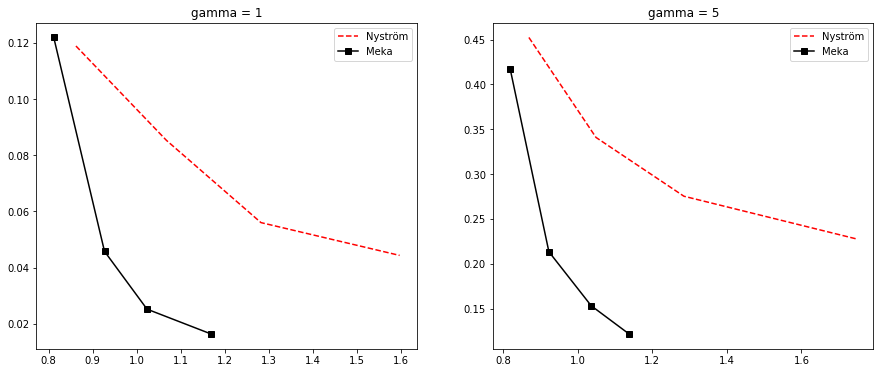

In [20]:
plt.figure(figsize=(15, 6))
for j, gamma in enumerate(gammas):
    plt.subplot(1, 2, j+1)
    plt.plot(all_time_Nys[j], all_err_Nys[j], linestyle='--', color='red')
    plt.plot(all_time_Meka[j], all_err_Meka[j], linestyle='-', marker='s', color='black')
    plt.legend(['Nyström', 'Meka'])
    plt.title('gamma = {}'.format(gamma))

In [35]:
print(list(zip(all_time_Nys[0], all_err_Nys[0])))
print(list(zip(all_time_Meka[0], all_err_Meka[0])))
print(list(zip(all_time_Nys[1], all_err_Nys[1])))
print(list(zip(all_time_Meka[1], all_err_Meka[1])))

[(0.8621459007263184, 0.11884227179932269), (1.0672259330749512, 0.08530139108744092), (1.2817130088806152, 0.056030740759745103), (1.5961339473724365, 0.044367216826588285)]
[(0.8117918968200684, 0.12187863620415551), (0.9269106388092041, 0.045802395901033265), (1.0232937335968018, 0.025250492325016739), (1.1685717105865479, 0.016419509952001168)]
[(0.8690030574798584, 0.45234903784900882), (1.0489680767059326, 0.34088778365133116), (1.2848200798034668, 0.27530389649477982), (1.7468020915985107, 0.22778554438858084)]
[(0.8191182613372803, 0.41665768403909054), (0.9226779937744141, 0.21337528595069283), (1.0362472534179688, 0.15313304869573985), (1.1376807689666748, 0.12170201470894677)]


## Kernel SVM classification

Kernel SVM amounts to solving the following problem:
$$
\min_{\alpha} \frac{1}{2} \alpha^T Q \alpha -e^T \alpha
$$
$$
s.t. 0 \leq \alpha \leq C
$$

Where $Q_{ij} = y_i y_j G_{ij}$, where G is the kernel matrix. We have to find $\alpha$. And then we will simply predict for an observation $x$:
$$
y_x = \sum_{i=1}^{n} \alpha_i^{*}y_i K(x, x_i)
$$

The goal here is to speed-up kernel SVM by using kernel approximations with MEKA and NYS. Of course, we expect some loss in accuracy, but that MEKA will still perform better while being time and memory efficient compared to NYS.

In [21]:
from sklearn.svm import SVC
p_train = 0.6

def kernel_train_test_split(kernel, y, prct_train):
    size_train = int(prct_train * len(kernel))
    K_train = kernel[:size_train, :size_train]
    K_test = kernel[size_train:, :size_train]
    y_train = y[:size_train]
    y_test = y[size_train:]
    return K_train, y_train, K_test, y_test

def data_train_test_split(X, y, prct_train):
    size_train = int(prct_train * len(X))
    X_train = X[:size_train, :size_train]
    X_test = X[size_train:, :size_train]
    y_train = y[:size_train]
    y_test = y[size_train:]
    return X_train, y_train, X_test, y_test

### With the true Kernel

As this is not the core of the article, we only perform 3-fold cross-validation to determine the best values of $\gamma$ and $\lambda$.

In [22]:
X_train, y_train, X_test, y_test = data_train_test_split(X, y, p_train)

In [23]:
Cs = [2**i for i in range(-10, 11)]
gammas = [2**i for i in range(-10, 11)]

In [24]:
from sklearn.model_selection import GridSearchCV
params = {'C': Cs, 'gamma': gammas}
clf = GridSearchCV(SVC(kernel='rbf'), params, cv=2)
clf.fit(X_train, y_train)

GridSearchCV(cv=2, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'gamma': [0.0009765625, 0.001953125, 0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024], 'C': [0.0009765625, 0.001953125, 0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [25]:
lbd = clf.best_params_['C']
gamma = clf.best_params_['gamma']
print('The best parameters by 2-fold cross-validation are: lambda={}, gamma={}'.format(lbd, gamma))

The best parameters by 2-fold cross-validation are: lambda=128, gamma=0.5


In [26]:
acc = clf.score(X_test, y_test)
print('The percentage accuracy for these values is %.2f%%'% (acc*100))

The percentage accuracy for these values is 97.35%


## With approximation methods

### a) Meka

In [27]:
c = 10
k = 20
m = 2 * k
rho = 3
Meka = MEKA(X=X, gamma=gamma, c=c, k=k, m=m, rho=rho)
K_tilde_Meka = Meka.compute_kernel()

In [28]:
K = rbf_kernel(X, gamma=gamma)

In [29]:
err_Meka = approx_error(K, K_tilde_Meka)
print(err_Meka)

0.00847340335454


In [30]:
K_train, y_train, K_test, y_test = kernel_train_test_split(K_tilde_Meka, y, p_train)

In [31]:
svc = SVC(C=lbd, gamma=gamma, kernel='precomputed')
svc.fit(K_train, y_train)
y_pred = svc.predict(K_test)
acc_Meka = np.mean(y_test == y_pred)
print('The percentage accuracy of the MEKA approximation for these values: %.2f%%'% (acc_Meka*100))

The percentage accuracy of the MEKA approximation for these values: 93.12%


## b) Nys

In [32]:
Nys = Nystrom(X=X, gamma=gamma, k=k, m=m)
K_tilde = Nys.compute_kernel()

In [33]:
K_train, y_train, K_test, y_test = kernel_train_test_split(K_tilde, y, p_train)

In [34]:
svc = SVC(C=lbd, gamma=gamma, kernel='precomputed')
svc.fit(K_train, y_train)
y_pred = svc.predict(K_test)
acc_Nys = np.mean(y_test == y_pred)
print('The percentage accuracy of the NYS approximation for these values: %.2f%%'% (acc_Nys*100))

The percentage accuracy of the NYS approximation for these values: 89.10%
